# Importing libraries


# IEECS Enrollment submission Task
# Maneet Gupta 24BBS0101

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import struct
from PIL import Image


# Part 1: Performing EDA

In [2]:
df = pd.read_csv("/kaggle/input/ieeecs/dataset_aiml_task/data.csv")

# Basic Info
print(df.info())
print(df.describe())

# Check Missing Values
print(df.isnull().sum())

# Display First Few Rows
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB
None
              label        pixel1        pixel2        pixel3        pixel4  \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean       4.500000      0.000900      0.006150      0.035333      0.101933   
std        2.872305      0.094689      0.271011      1.222324      2.452871   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        2.000000      0.000000      0.000000      0.000000      0.000000   
50%        4.500000      0.000000      0.000000      0.000000      0.000000   
75%        7.000000      0.000000      0.000000      0.000000      0.000000   
max        9.000000     16.000000     36.000000    226.000000    164.000000   

             pixel5        pixel6        pixel7        pixel8        pixel9  \
count  60000.000000  60000.000000  60000.00000

### Just a small remark: soooo these are pixel values for images... hmm

#### so there are no null value, i.e. the data is pretty much cleaned up and nan values are ommitted. all the values are between 0-255, i.e. standard rgb values as expected

## Proceeding forward with loading images 

Loaded 60000 images of size 28x28


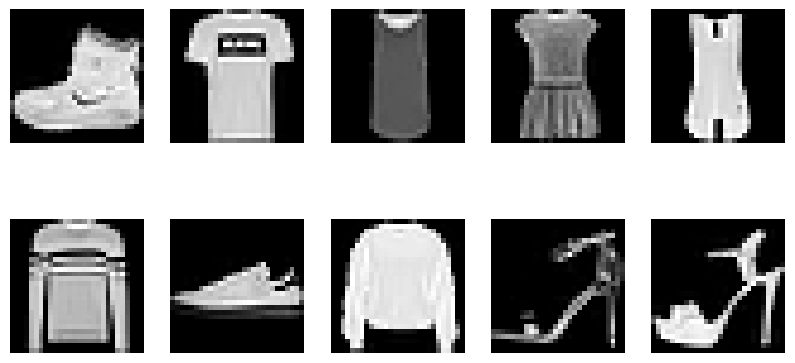

In [3]:
def load_idx_images(filename):
    with open(filename, 'rb') as f:
        _, num, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols)
    return images

images = load_idx_images("/kaggle/input/ieeecs/dataset_aiml_task/images-idx3-ubyte")

# Check Shape
print(f"Loaded {images.shape[0]} images of size {images.shape[1]}x{images.shape[2]}")

# Display Sample Images
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.axis('off')
plt.show()


# loading lables and getting label distribution to see how many datapoints are there for each label


Loaded 60000 labels
Unique Labels: [0 1 2 3 4 5 6 7 8 9]


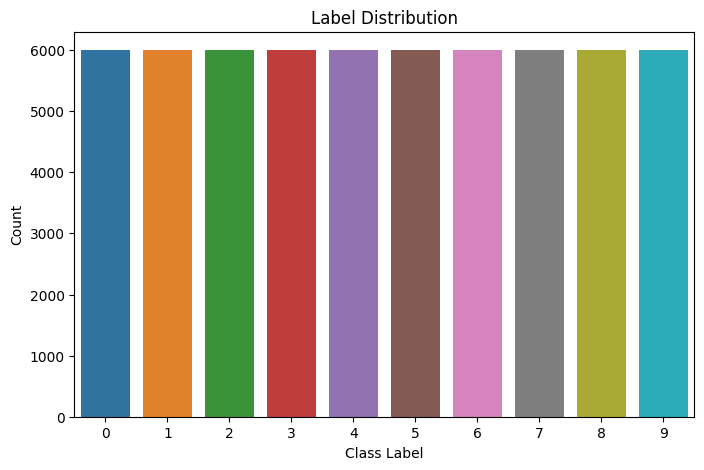

In [4]:
def load_idx_labels(filename):
    with open(filename, 'rb') as f:
        _, num = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

labels = load_idx_labels("/kaggle/input/ieeecs/dataset_aiml_task/labels-idx1-ubyte")

# Check Labels
print(f"Loaded {len(labels)} labels")
print(f"Unique Labels: {np.unique(labels)}")

# Bar Plot of Label Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=labels)
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.title("Label Distribution")
plt.show()


### According to data there are 10 classes to identify from. each class having 6000 samples. as per the images given below it seems it is a clothing identifier ?? 


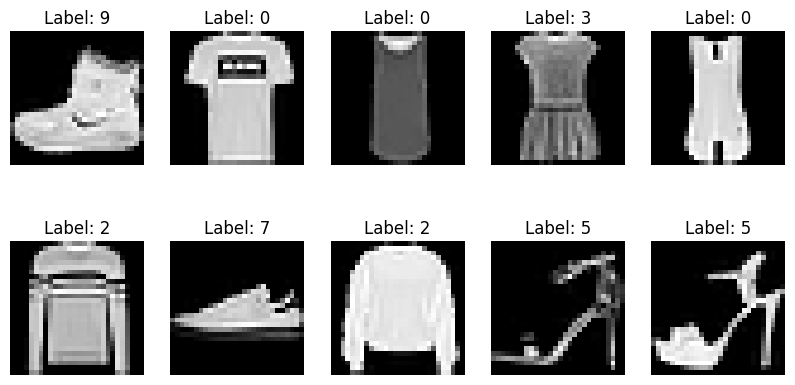

In [5]:
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')
plt.show()


# Part 2 Logistic Regression 
## Logistic Regression is a statistical model used for binary and multi-class classification(Which is used here for classification of clothings). It predicts probabilities using the sigmoid function (The weird S shaped graph thingy). We are not using Linear regression because of categorical nature of data as seen in EDA. 

btw linear regression is used for continuous outputs ( like predicting housing prices ) 

In [6]:
!pip install shap --quiet

In [7]:
import numpy as np
import pandas as pd
import struct
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import shap


#redefining load_idx_images to return rows and cols too (Preprocessing)

def load_idx_images(filename):
    with open(filename, 'rb') as f:
        _, num, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows * cols)
    return images, rows, cols



# Loading dataset
X, img_rows, img_cols = load_idx_images("/kaggle/input/ieeecs/dataset_aiml_task/images-idx3-ubyte")
y = load_idx_labels("/kaggle/input/ieeecs/dataset_aiml_task/labels-idx1-ubyte")

print(f"📷 Loaded {X.shape[0]} images of size {img_rows}x{img_cols}")
print(f"🏷 Loaded {y.shape[0]} labels")

# Batch normalization
X = X / 255.0  # Normalize pixel values to range [0,1] (its better to work with normalized ranges :D)



📷 Loaded 60000 images of size 28x28
🏷 Loaded 60000 labels


# Splitting the data 

Why did the dataset refuse to split evenly? Ans. It had attachment issues! 

In [8]:
from sklearn.model_selection import train_test_split

# 70% Train, 15% Validation, 15% Test (Some legends say that the best you split, the best you did)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"✅ Training set size: {X_train.shape[0]}")
print(f"✅ Validation set size: {X_val.shape[0]}")
print(f"✅ Testing set size: {X_test.shape[0]}")


✅ Training set size: 42000
✅ Validation set size: 9000
✅ Testing set size: 9000


### Using Limited-memory Broyden–Fletcher–Goldfarb–Shanno (LBFGS) solver to optimize weights for LR model

In [9]:
log_reg = LogisticRegression(max_iter=2000, solver='lbfgs', verbose=1)  # Enable tracking
log_reg.fit(X_train, y_train)

# Predictions
y_train_pred = log_reg.predict(X_train)
y_val_pred = log_reg.predict(X_val)
y_test_pred = log_reg.predict(X_test)


✅ Train Accuracy: 0.8855
✅ Validation Accuracy: 0.8537
✅ Test Accuracy: 0.8496

Classification Report (Val Set):
              precision    recall  f1-score   support

           0       0.77      0.82      0.80       856
           1       0.98      0.96      0.97       960
           2       0.76      0.76      0.76       895
           3       0.85      0.88      0.86       897
           4       0.77      0.80      0.78       916
           5       0.93      0.94      0.94       888
           6       0.63      0.57      0.60       876
           7       0.91      0.93      0.92       904
           8       0.95      0.94      0.94       879
           9       0.95      0.94      0.95       929

    accuracy                           0.85      9000
   macro avg       0.85      0.85      0.85      9000
weighted avg       0.85      0.85      0.85      9000



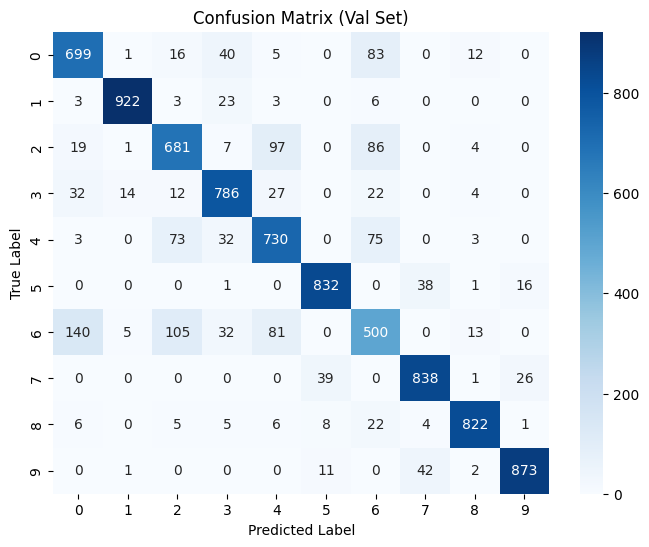

In [10]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Accuracy
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"✅ Train Accuracy: {train_acc:.4f}")
print(f"✅ Validation Accuracy: {val_acc:.4f}")
print(f"✅ Test Accuracy: {test_acc:.4f}")

# Precision, Recall, F1-Score
print("\nClassification Report (Val Set):")
print(classification_report(y_val, y_val_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Val Set)")
plt.show()


## From the analysis above we can conclude
1. Class 1 is best classified by the model
2. class 6 is least classfied and confused by model
3. the model achieves a avg score of 85 % which is acceptable for linear model

For further observation, lets check the plot of loss curves


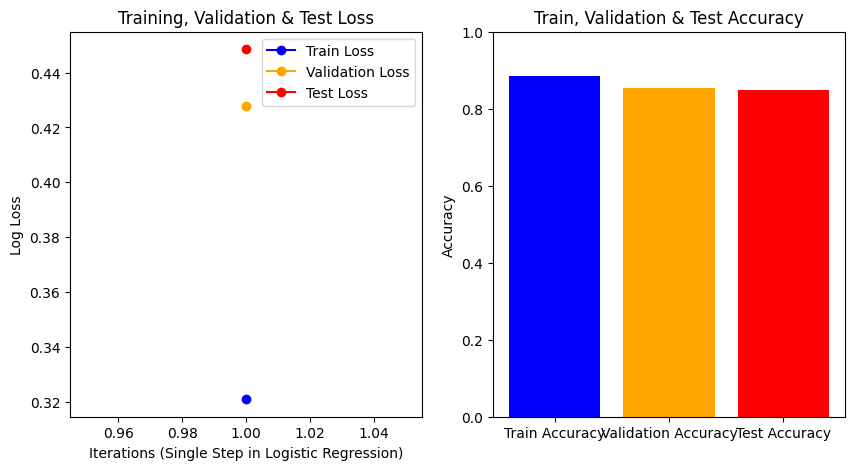

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Loss values (since Logistic Regression doesn’t have epochs, we approximate using log-loss)
from sklearn.metrics import log_loss

train_loss = log_loss(y_train, log_reg.predict_proba(X_train))
val_loss = log_loss(y_val, log_reg.predict_proba(X_val))
test_loss = log_loss(y_test, log_reg.predict_proba(X_test))

epochs = np.arange(1, 2)  # Logistic Regression doesn't use multiple epochs

plt.figure(figsize=(10,5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, [train_loss], label="Train Loss", marker='o', color='blue')
plt.plot(epochs, [val_loss], label="Validation Loss", marker='o', color='orange')
plt.plot(epochs, [test_loss], label="Test Loss", marker='o', color='red')
plt.xlabel("Iterations (Single Step in Logistic Regression)")
plt.ylabel("Log Loss")
plt.title("Training, Validation & Test Loss")
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.bar(["Train Accuracy", "Validation Accuracy", "Test Accuracy"], [train_acc, val_acc, test_acc], color=['blue', 'orange', 'red'])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Train, Validation & Test Accuracy")

plt.show()


## According to Curves and Bar graphs we can conculde that model has achieved a good generalization of the data above as train loss is well below the train and val loss. 

## Also the accuracy is pretty much same and hence we can conclude that model is able to differentiate between the classes for unseen images too. 

# Conclusion: Model converged properly as intended

In [12]:
shap_values_array = shap_values.values if hasattr(shap_values, 'values') else shap_values
num_samples = shap_values_array.shape[0]
X_test_df = pd.DataFrame(X_test[:num_samples], columns=[f"Pixel {i}" for i in range(X_test.shape[1])])
shap_values_mean = np.mean(np.abs(shap_values_array), axis=2)  # Shape (9000, 784)
shap_df = pd.DataFrame(shap_values_mean, columns=[f"Feature {i}" for i in range(X_test.shape[1])])
shap.summary_plot(shap_values_mean, X_test_df)


NameError: name 'shap_values' is not defined

# Part-3 CNN Model
## CNNs are deep learning models designed for image processing, using convolutional layers to detect patterns like edges and textures. They excel at tasks like image classification and object detection by learning spatial hierarchies of features. I am expecting a much more accuracy with this model as data is in form of images

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
import struct

# Load Dataset
image_file = "/kaggle/input/ieeecs/dataset_aiml_task/images-idx3-ubyte"
label_file = "/kaggle/input/ieeecs/dataset_aiml_task/labels-idx1-ubyte"




def load_idx_images(filename):
    with open(filename, 'rb') as f:
        _, num, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows * cols)
    return images

def load_idx_labels(filename):
    with open(filename, 'rb') as f:
        _, num = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

X = load_idx_images(image_file)
y = load_idx_labels(label_file)

# Normalize images (0-1 range)
X = X.astype('float64') / 255.0

# Reshape for CNN (assume grayscale images)

X = X.reshape(X.shape[0], 28, 28, 1)  

# One-hot encode labels 
num_classes = len(np.unique(y))
y = to_categorical(y, num_classes)

# Train-Validation-Test Split (80-10-10)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=21)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=21)

print(f"Training set: {X_train.shape}, Labels: {y_train.shape}")
print(f"Validation set: {X_val.shape}, Labels: {y_val.shape}")
print(f"Testing set: {X_test.shape}, Labels: {y_test.shape}")


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Build CNN Model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Prevent Overfitting
    Dense(num_classes, activation='softmax')
])

# Compile Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


## using Maxpooling layers for reducing the spatial dimensions of feature maps. using flatten to change to 1d, and dense layers for prevention of overfitting

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32,  
)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Evaluate on Test Set
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
plt.figure(figsize=(12,5))

# Loss Curve
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

# Accuracy Curve
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.show()


### okay so according to learning curves, the model is overfitting on the model (high distance between train and val loss (and accuracy) which is not ideal and shows that model is taking noise into consideration too. Also there are many highs and lows in the val curve and its slightly increasing showing overfitting too.

#### using any different approach to prevent overfitting

In [ ]:
# Build CNN Model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2,2)),
   
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Prevent Overfitting
    Dense(num_classes, activation='softmax')
])

# Compile Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Added dropout layer to prevent further overfitting

In [ ]:


history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32,
   
)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Evaluate on Test Set
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
plt.figure(figsize=(12,5))

# Loss Curve
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

# Accuracy Curve
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.show()


## After adding dropout layers the accuracy stays the same but model has obtained a sense of generalization as there is much less distance now between the learning curves which shows that our trick worked. 

## now predicting with model


In [ ]:
# Predict on a few test samples
num_samples = 10
predictions = model.predict(X_test[:num_samples])

# Convert one-hot encoded predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test[:num_samples], axis=1)
# Plot Predictions
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(X_test[i].reshape(28, 28), cmap='gray')
    ax.set_title(f"Pred: {predicted_labels[i]}\nTrue: {true_labels[i]}")
    ax.axis("off")
plt.show()


# Hence in conclusion the model works pretty fine mostly predicting the labels correctly. it is confused in 3,4,6 classes but i think thats fine 😅 i guess. 


# Thanks for reviewing my submission hope you like it!!!!
# Made with Love by Maneet Gupta 24BBS0101